In [164]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from plot import *
import seaborn as sns
import re

plt.style.use('seaborn-whitegrid')
logging.basicConfig(level=logging.CRITICAL)

/tmp/ipykernel_153345/1111328684.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [166]:
def format_df_for_table(data_seed_aucs):
    # data_seed_aucs is a dict of structure data_seed_aucs[dataset][seed][algo] = auc
    # we need to format it into a df with columns: algo, dataset, value where value is the mean auc over seeds
    data = []
    for dataset, seed_aucs in data_seed_aucs.items():
        for seed, aucs in seed_aucs.items():
            for algo, auc in aucs.items():
                data.append({'dataset': dataset, 'seed': seed, 'algo': algo, 'auc': auc})
    df = pd.DataFrame(data)
    df = df.groupby(['dataset', 'algo']).agg({'auc': ['mean', 'std', 'sem']}).reset_index()
    df.columns = ['dataset', 'algo', 'mean', 'std', 'sem']
    return df

In [167]:
# choices = ["all_avg", "modular_ablation", "modular", "monolithic", "modmod_budget", "fedavg_monolithic_budget" "fedavg_modular_budget" "recv_modular" "recv_monolithic"
# "modmod_topology" "fedavg_modular_topology" "fedavg_monolithic_topology"]
# what_to_plot = "all_avg"
# what_to_plot = "modular"
# what_to_plot = "monolithic"
# what_to_plot = "recv_modular"
# what_to_plot = "recv_monolithic"
# what_to_plot = "fedavg_monolithic_budget"



# what_to_plot = "fedavg_modular_topology"
# what_to_plot = "fedavg_monolithic_topology"
what_to_plot = "modmod_topology"


what_to_plot = "monolithic_fl_zoo"
# what_to_plot = "modular_fl_zoo"

In [168]:
datasets = ["mnist", "kmnist", "fashionmnist", "combined", "cifar100"]
# datasets = ["combined"]
# datasets = ["mnist", "kmnist", "fashionmnist"]
# datasets = ["mnist", "kmnist"]
# datasets = ["mnist", "combined"]
# datasets = ["mnist", "cifar100"]
# datasets = ["combined"]
experiment_folder = "experiment_results"


use_contrastive = True

viz = False
seeds = [0, 1, 2, 3, 4, 5, 6, 7]
tasks=None
agent_ids = None
ax=None
sync_bases = [True]
opt_with_randoms = [False]

metric='test_acc'


# agent_ids=['agent_3']
# tasks=[19]
# tasks=[3]
# tasks=[9]

num_tryout_epochs = 20
max_num_modules_tryout = 3
num_shared_module_list = [1,2,3,4]

fedavg_comm_freq = [5, 10, 20, 50, 100]

recv_num_queries = [10, 20, 30]
recv_comm_freq = [9, 16, 50]

def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

if what_to_plot == "all_avg":
    algos = ['monolithic', 'modular']
    mode = "avg"
elif "modular" in what_to_plot or "modmod" in what_to_plot:
    algos = ['modular']
    mode = "current"
elif "monolithic" in what_to_plot:
    algos = ['monolithic']
    mode = "avg"
else:
    raise ValueError("Invalid choice")

# ## TMP
# mode='avg'

use_contrastive_list = [False]

freeze_candidate_module = False
no_sparse_basis_ls = [True]

if what_to_plot == "modular_ablation":
    transfer_decoder_ls = [True, False]
    transfer_structure_ls = [True, False]
else:
    transfer_decoder_ls = [True]
    transfer_structure_ls = [True]

In [169]:
def get_save_dirs_modmod(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for sync_base in sync_bases:
        for opt_with_random in opt_with_randoms:
            for use_contrastive_opt in use_contrastive_list:
                for transfer_decoder in transfer_decoder_ls:
                    for transfer_structure in transfer_structure_ls:
                        for no_sparse_basis in no_sparse_basis_ls:
                            experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            if dataset == "combined":
                                experiment_name = f"leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            else:
                               experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            if use_contrastive_opt:
                                name += "_contrastive"
                            name = f'jorge_setting_lowest_id_sync_{sync_base}_rand_{opt_with_random}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}'
                            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                    dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs



def get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder=None):
    if budget_experiment_folder is None:
        budget_experiment_folder = experiment_folder

    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for num_shared_module in num_shared_module_list:
        for sync_base in sync_bases:
            for opt_with_random in opt_with_randoms:
                for use_contrastive_opt in use_contrastive_list:
                    for transfer_decoder in transfer_decoder_ls:
                        for transfer_structure in transfer_structure_ls:
                            for no_sparse_basis in no_sparse_basis_ls:
                                if dataset == "combined":
                                    experiment_name = f"leep_tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                else:
                                    experiment_name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                if use_contrastive_opt:
                                    name += "_contrastive"
                                save_dirs[name] = get_save_dir(budget_experiment_folder, experiment_name,
                                                        dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs


def get_save_dirs_recv(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    experiment_name = f"jorge_setting_recv"
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f"recv_{algo}"
            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir('.', 'cifar_heuristic_results_small_mem_32/budget/heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_16',
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir('cifar_heuristic_results', 'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True',
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir('.', 'rerun_recv_latest_main_results',
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir('cifar_budget_experiment_results','heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_16',
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir('.', 'rerun_recv_latest_main_results_query_all_post_comm',
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("heuristic_experiment_results", "heuristic_experiment_results/heuristic_budget_20_enforce_balance_False_mem_32_freq_16",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir(".", "recv_results",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("rerun_opt_heuristic_experiment_results", "recv_mem_32_freq_16",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("rerun_opt_heuristic_experiment_results", "recv_mem_100_freq_16",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("rerun_opt_heuristic_experiment_results", "heuristic_budget_20_enforce_balance_True_mem_32",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("rerun_opt_heuristic_experiment_results", "heuristic_budget_20_enforce_balance_True_mem_400",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("rerun_opt_heuristic_experiment_results", "heuristic_budget_20_enforce_balance_True_mem_160",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
            # save_dirs[name] = get_save_dir("after_fix_vanilla_cifar_results", "heuristic_budget_20_enforce_balance_True_mem_160_sync_base_True_hash_True",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed) 
            # save_dirs[name] = get_save_dir("after_fix_vanilla_cifar_results", "heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed) 
            # save_dirs[name] = get_save_dir("cifar_heuristic_results", "heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed) 
            # save_dirs[name] = get_save_dir("cifar_heuristic_results","heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed) 
            # save_dirs[name] = get_save_dir("budget","heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_16",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed) 
            # save_dirs[name] = get_save_dir("budget","heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_16",
            #                                     dataset, algo, num_trains_per_class, use_contrastive_opt, seed) 
    return save_dirs
    

def get_save_dirs_base(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for no_sparse_basis in no_sparse_basis_ls:
                if no_sparse_basis:
                    base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
                else:
                    base_experiment_name = "vanilla_jorge_setting"
                name = f'{algo}_no_sparse_basis_{no_sparse_basis}'
                if use_contrastive_opt:
                    name += "_contrastive"
                save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name,
                                        dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs

def get_save_dirs_fedavg(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f'fedavg_{algo}'
            save_dirs[name] = get_save_dir(experiment_folder, "jorge_setting_fedavg",
                                            dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


# def get_save_dirs_fedavg_budget(dataset, seed, budget_experiment_folder=None):
#     if budget_experiment_folder is None:
#         budget_experiment_folder = experiment_folder
#     save_dirs = {}
#     num_trains_per_class = 64 if dataset != "cifar100" else 256
#     for algo in algos:
#         for use_contrastive_opt in use_contrastive_list:
#             for freq in fedavg_comm_freq:
#                 name = f'fedavg_{algo}_f_{freq}'
#                 save_dirs[name] = get_save_dir(budget_experiment_folder, f"comm_freq_{freq}",
#                                                 dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
#     return save_dirs

# def get_save_dirs_recv_budget(dataset, seed, budget_experiment_folder=None):
#     if budget_experiment_folder is None:
#         budget_experiment_folder = experiment_folder
#     save_dirs = {}
#     num_trains_per_class = 64 if dataset != "cifar100" else 256
#     for algo in algos:
#         for use_contrastive_opt in use_contrastive_list:
#             for num_queries in recv_num_queries:
#                 for freq in recv_comm_freq:
#                     name = f'recv_{algo}_nq_{num_queries}_f_{freq}'
#                     # list all folder in budget_experiment_results that has the pattern "*comm_freq_{freq}_num_queries_{num_queries}*"
#                     for folder in os.listdir(budget_experiment_folder):
#                         if f"comm_freq_{freq}_num_queries_{num_queries}" in folder:
#                             save_dirs[name] = get_save_dir(budget_experiment_folder, folder,
#                                                 dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
#     return save_dirs



def get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder=None, patterns=None):
    if patterns is None:
        patterns = [r".*"]
    if root_experiment_folder is None:
        root_experiment_folder = experiment_folder
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for folder in os.listdir(root_experiment_folder):
                if not os.path.isdir(os.path.join(root_experiment_folder, folder)) or not any([re.search(pattern, folder) for pattern in patterns]):
                    continue
                save_dirs[folder] = get_save_dir(root_experiment_folder, folder,
                                    dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


def get_save_dirs(dataset, seed):
    save_dirs = {}

    if what_to_plot == "all_avg" or what_to_plot == "modular" or what_to_plot == "monolithic":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        if "modular" in algos:
            save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_recv(dataset, seed))
    elif what_to_plot == "modular_ablation":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
    elif what_to_plot == "modmod_budget":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder="budget_experiment_results/modmod"))
    elif "fedavg" in what_to_plot and "topology" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="jorge_setting_fedavg/comm_freq_5",
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="topology_experiment_results/topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
        # mnist, fashionmnist, kmnist for fedavg monolithic
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="rerun_topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="new_topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
        patterns=[r"disconnect", r"ring", r"server", r"tree"]))

    elif "fedavg" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="budget_experiment_results/jorge_setting_fedavg"))
    elif "recv" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="budget_experiment_results/jorge_setting_recv_variable_shared_memory_size"))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="modular_backward_cifar_heuristic_results_small_mem_32/budget"))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="cifar_heuristic_results_small_mem_32_results/budget"))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="combined_recv_results/combined_recv_results"))
        # save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="combined_recv_remove_neighbors_results"))

        if dataset == "cifar100":
            # remove all keys that has "mem_size" in it from save_dirs
            save_dirs = {k: v for k, v in save_dirs.items() if "mem_size" not in k}
        else:
            # remove all keys that has "heuristic"
            save_dirs = {k: v for k, v in save_dirs.items() if "heuristic" not in k}
    elif what_to_plot == "modmod_topology":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="new_topology_experiment_results/modmod",
        patterns=[r"disconnect", r"ring", r"server", r"tree"]))
    elif 'fl_zoo' in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, 
        # root_experiment_folder="more_fl",
        root_experiment_folder="more_fl_fix_root_agent_results",
        ))
        # patterns=[r"fedcurv"]))
        # patterns=[r"fedprox"]))
    else:
        raise ValueError("Invalid choice")
    return save_dirs

In [170]:
remap_name = {
    
    
             "modular_no_sparse_basis_True" : "modular (baseline)",
              "monolithic_no_sparse_basis_True": "monolithic (baseline)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "modmod",

            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules (no sync)",
            # "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure (no sync)",
            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure + decoder (no sync)",

             "recv_modular": "modular data",
             "fedavg_modular": "modular FedAvg",
             "recv_monolithic": "monolithic data",
            "fedavg_monolithic": "monolithic FedAvg",

            # 'tryout_epochs_20_max_modules_3_num_shared_modules_1_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=1)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_2_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=2)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_3_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=3)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_4_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=4)',

            # 'comm_freq_5': 'FedAvg Monolithic (f=5)',
            # 'comm_freq_10': 'FedAvg Monolithic (f=10)',
            # 'comm_freq_20': 'FedAvg Monolithic (f=20)',
            # 'comm_freq_50': 'FedAvg Monolithic (f=50)',
            # 'comm_freq_100': 'FedAvg Monolithic (f=100)',

            # 'fedavg_modular_f_5': 'FedAvg Modular (f=5)',
            # 'fedavg_modular_f_10': 'FedAvg Modular (f=10)',
            # 'fedavg_modular_f_20': 'FedAvg Modular (f=20)',
            # 'fedavg_modular_f_50': 'FedAvg Modular (f=50)',
            # 'fedavg_modular_f_100': 'FedAvg Modular (f=100)',

            # 'recv_monolithic_nq_10_f_9': 'Recv Monolithic (nq=10, f=9)',
            # 'recv_monolithic_nq_10_f_16': 'Recv Monolithic (nq=10, f=16)',
            # 'recv_monolithic_nq_10_f_50': 'Recv Monolithic (nq=10, f=50)',
            # 'recv_monolithic_nq_20_f_9': 'Recv Monolithic (nq=20, f=9)',
            # 'recv_monolithic_nq_20_f_16': 'Recv Monolithic (nq=20, f=16)',
            # 'recv_monolithic_nq_20_f_50': 'Recv Monolithic (nq=20, f=50)',
            # 'recv_monolithic_nq_30_f_9': 'Recv Monolithic (nq=30, f=9)',
            # 'recv_monolithic_nq_30_f_16': 'Recv Monolithic (nq=30, f=16)',
            # 'recv_monolithic_nq_30_f_50': 'Recv Monolithic (nq=30, f=50)',

            # 'recv_modular_nq_10_f_9': 'Recv Modular (n=10, f=9)',
            # 'recv_modular_nq_10_f_16': 'Recv Modular (n=10, f=16)',
            # 'recv_modular_nq_10_f_50': 'Recv Modular (n=10, f=50)',
            # 'recv_modular_nq_20_f_9': 'Recv Modular (n=20, f=9)',
            # 'recv_modular_nq_20_f_16': 'Recv Modular (n=20, f=16)',
            # 'recv_modular_nq_20_f_50': 'Recv Modular (n=20, f=50)',
            # 'recv_modular_nq_30_f_9': 'Recv Modular (n=30, f=9)',
            # 'recv_modular_nq_30_f_16': 'Recv Modular (n=30, f=16)',
            # 'recv_modular_nq_30_f_50': 'Recv Modular (n=30, f=50)',

            # dict_keys(['modular_no_sparse_basis_True', 'mem_size_100_comm_freq_9_num_queries_10', 'mem_size_32_comm_freq_50_num_queries_20', 'mem_size_150_comm_freq_16_num_queries_30', 'mem_size_300_comm_freq_9_num_queries_30', 'mem_size_200_comm_freq_9_num_queries_20', 'mem_size_50_comm_freq_16_num_queries_10', 'mem_size_100_comm_freq_16_num_queries_20', 'mem_size_32_comm_freq_50_num_queries_10', 'mem_size_32_comm_freq_50_num_queries_30'])

            'mem_size_32_comm_freq_50_num_queries_10': 'Recv Modular (mem=32, f=50, n=10)',
            'mem_size_32_comm_freq_50_num_queries_20': 'Recv Modular (mem=32, f=50, n=20)',
            'mem_size_32_comm_freq_50_num_queries_30': 'Recv Modular (mem=32, f=50, n=30)',
            'mem_size_50_comm_freq_16_num_queries_10': 'Recv Modular (mem=50, f=16, n=10)',
            'mem_size_100_comm_freq_9_num_queries_10': 'Recv Modular (mem=100, f=9, n=10)',
            'mem_size_100_comm_freq_16_num_queries_20': 'Recv Modular (mem=100, f=16, n=20)',
            'mem_size_150_comm_freq_16_num_queries_30': 'Recv Modular (mem=150, f=16, n=30)',
            'mem_size_200_comm_freq_9_num_queries_20': 'Recv Modular (mem=200, f=9, n=20)',
            'mem_size_300_comm_freq_9_num_queries_30': 'Recv Modular (mem=300, f=9, n=30)',

            'topology_server_edge_drop_0.0': 'server',
            'topology_tree_edge_drop_0.0': 'tree',
            'topology_ring_edge_drop_0.0': 'ring',

            # 'topology_random_edge_drop_0.7': 'random (p=0.7)',
            # 'topology_random_edge_drop_0.5': 'random (p=0.5)',
            # 'topology_random_edge_drop_0.25': 'random (p=0.25)',
            # 'topology_random_edge_drop_0.9': 'random (p=0.9)',

            # 'topology_random_disconnect_edge_drop_0.25': 'random disconnect (p=0.25)',
            # 'topology_random_disconnect_edge_drop_0.5': 'random disconnect (p=0.5)',
            # 'topology_random_disconnect_edge_drop_0.7': 'random disconnect (p=0.7)',
            # 'topology_random_disconnect_edge_drop_0.9': 'random disconnect (p=0.9)',

             'topology_random_disconnect_edge_drop_0.25': 'random (p=0.25)',
            'topology_random_disconnect_edge_drop_0.5': 'random (p=0.5)',
            'topology_random_disconnect_edge_drop_0.7': 'random (p=0.7)',
            'topology_random_disconnect_edge_drop_0.9': 'random (p=0.9)',


            "fedprox_mu_0.001_comm_freq_5": "FedProx (mu=0.001)",
            "fedprox_mu_0.01_comm_freq_5": "FedProx (mu=0.01)",
            "fedprox_mu_0.1_comm_freq_5": "FedProx (mu=0.1)",
            "fedprox_mu_1.0_comm_freq_5": "FedProx (mu=1.0)",

"fedcurv_mu_0.001_comm_freq_5": "FedCurv (mu=0.001)",
"fedcurv_mu_0.01_comm_freq_5": "FedCurv (mu=0.01)",
"fedcurv_mu_0.1_comm_freq_5": "FedCurv (mu=0.1)",
"fedcurv_mu_1.0_comm_freq_5": "FedCurv (mu=1.0)",

    'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_50': 'data (b=80, f=50)',
    'heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_50': 'data (b=20, f=50)',
    'heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_9': 'data (b=40, f=9)',
    'heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_16': 'data (b=20, f=16)',
    'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_16': 'data (b=80, f=16)',
    'heuristic_budget_20_enforce_balance_False_mem_160_sync_base_False_hash_True_comm_freq_9': 'data (b=20, f=9)',
    'heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_50': 'data (b=40, f=50)',
    'heuristic_budget_80_enforce_balance_False_mem_640_sync_base_False_hash_True_comm_freq_9': 'data (b=80, f=9)',
    'heuristic_budget_40_enforce_balance_False_mem_320_sync_base_False_hash_True_comm_freq_16': 'data (b=40, f=16)'


             }

num_colors = len(remap_name)
# color_map = plt.cm.get_cmap('tab20b', num_colors)
color_map = plt.cm.get_cmap('tab10', num_colors)
colors = color_map(range(num_colors))

# colormap = {
#     'modular (baseline)': colors[0],
#     "monolithic (baseline)": colors[1],
#     'modmod': colors[2],
#     'Recv Modular': colors[3],
#     'FedAvg Modular': colors[4],
#     'Recv Monolithic': colors[5],
#     'FedAvg Monolithic': colors[6],
#     'transfer modules': colors[7],
#     'transfer modules + structure': colors[8],
#     'modmod (k=1)': colors[9],
#     'modmod (k=2)': colors[10],
#     'modmod (k=3)': colors[11],
#     'modmod (k=4)': colors[12],


# }

colormap = {k: colors[i] for i, k in enumerate(remap_name.values())}


/tmp/ipykernel_153345/3304523344.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_colors)


In [171]:
dataset_seed_aucs, dataset_agg_dfs = load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax, mode=mode,
                                               metric=metric, strict=False)

In [172]:
# df = dataset_agg_dfs['mnist']
# df = df[df['name'] == 'monolithic_no_sparse_basis_True']
# df

In [173]:
# dataset_agg_dfs['mnist']['name'].unique()

In [174]:
# df = dataset_agg_dfs['combined']
# df = df[df['name'] == 'recv_modular']
# df = df[df['epoch'] == 101]
# df['test_acc_mean'].mean()

In [175]:
# HACK: for fedavg just throw away the epoch 5 since it's not recorded in the later code for some reasons
if what_to_plot == "fedavg_monolithic_topology":
    dataset_agg_dfs = {k: df[df['epoch'] != 5] for k, df in dataset_agg_dfs.items()}

In [176]:
# df = dataset_agg_dfs['combined']
# df[df['name'] == 'recv_modular']

In [177]:
# df = df[df['name'] == 'recv_modular']
# # df = df[df['name'] == 'modular_no_sparse_basis_True']
# df

In [178]:
dataset_agg_dfs['cifar100']['name'].unique()
dataset_agg_dfs['mnist']['name'].unique()

array(['monolithic_no_sparse_basis_True', 'fedavg_monolithic',
       'fedprox_mu_0.001_comm_freq_5', 'fedprox_mu_0.1_comm_freq_5',
       'fedcurv_mu_1.0_comm_freq_5', 'fedprox_mu_1.0_comm_freq_5',
       'fedcurv_mu_0.01_comm_freq_5', 'fedcurv_mu_0.1_comm_freq_5',
       'fedprox_mu_0.01_comm_freq_5', 'fedcurv_mu_0.001_comm_freq_5'],
      dtype=object)

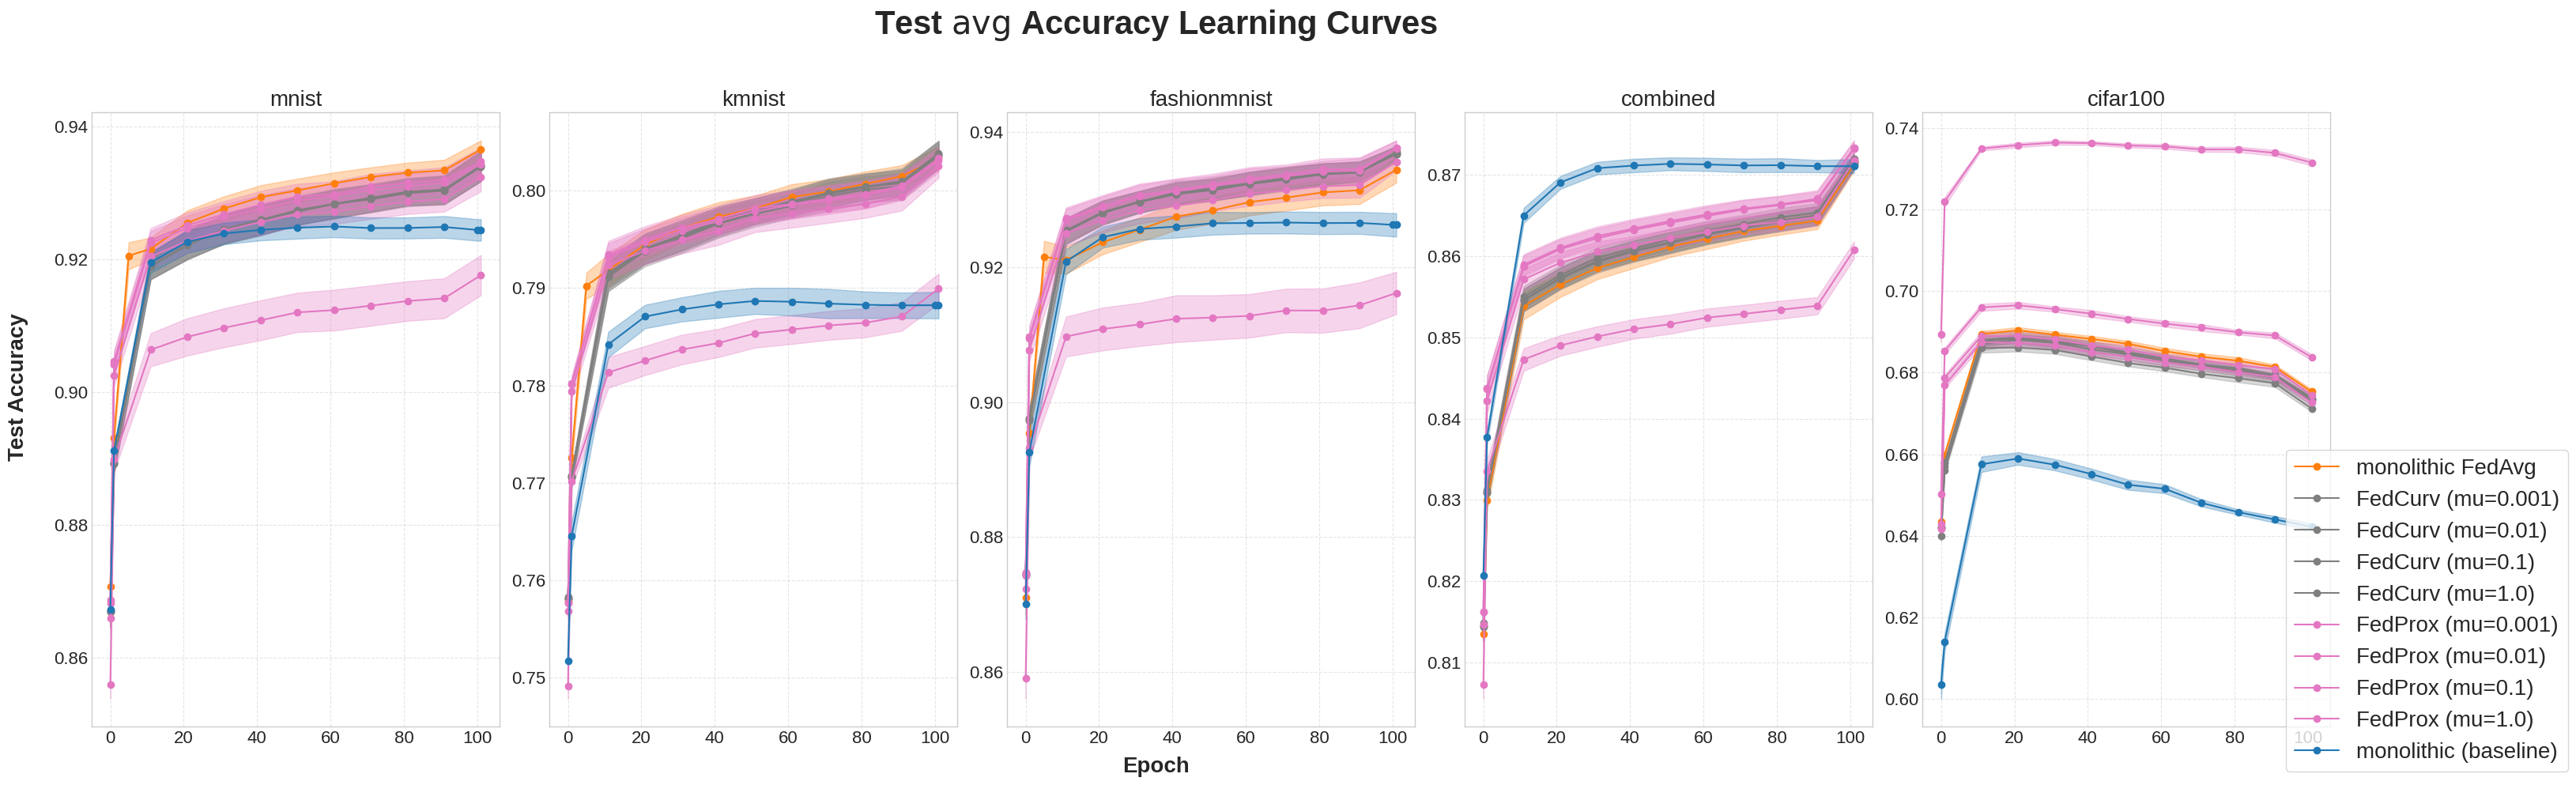

In [179]:
plot_learning_curve_dataset(dataset_agg_dfs, remap_name=remap_name, colormap=colormap,
                            mode=mode, save_fig_path=f'Figures/{what_to_plot}_lc.pdf',
                            error_type='sem',
                            metric=metric)

In [180]:
custom_algo_order = ['modmod',
 'random (p=0.25)',
 'random (p=0.5)',
 'random (p=0.7)',
 'random (p=0.9)',
 'modular (baseline)',
 'server',
 'ring',
 'tree']



# custom_algo_order = ['monolithic FedAvg',
#  'random (p=0.25)',
#  'random (p=0.5)',
#  'random (p=0.7)',
#  'random (p=0.9)',
#  'monolithic (baseline)',
#  'server',
#  'ring',
#  'tree']


# custom_algo_order = ['modular FedAvg',
#  'random (p=0.25)',
#  'random (p=0.5)',
#  'random (p=0.7)',
#  'random (p=0.9)',
#  'modular (baseline)',
#  'server',
#  'ring',
#  'tree']

In [181]:
colormap_alternative_0 = {
    'modmod': '#1f77b4',  # Blue, p=0.0
    'random (p=0.25)': '#4e90a4',  # Transition color
    'random (p=0.5)': '#7daa94',  # Transition color
    'random (p=0.7)': '#acC484',  # Transition color
    'random (p=0.9)': '#dbcE74',  # Transition color
    'modular (baseline)': '#ff7f0e',  # Orange, p=1.0
    'server': '#2ca02c',  # Green, distinct topology
    'ring': '#d62728',  # Red, distinct topology
    'tree': '#9467bd'   # Purple, distinct topology
}

# colormap_alternative_0 = {
#     'monolithic FedAvg': '#1f77b4',  # Blue, p=0.0
#     'random (p=0.25)': '#4e90a4',  # Transition color
#     'random (p=0.5)': '#7daa94',  # Transition color
#     'random (p=0.7)': '#acC484',  # Transition color
#     'random (p=0.9)': '#dbcE74',  # Transition color
#     'monolithic (baseline)': '#ff7f0e',  # Orange, p=1.0
#     'server': '#2ca02c',  # Green, distinct topology
#     'ring': '#d62728',  # Red, distinct topology
#     'tree': '#9467bd'   # Purple, distinct topology
# }


# colormap_alternative_0 = {
#     'modular FedAvg': '#1f77b4',  # Blue, p=0.0
#     'random (p=0.25)': '#4e90a4',  # Transition color
#     'random (p=0.5)': '#7daa94',  # Transition color
#     'random (p=0.7)': '#acC484',  # Transition color
#     'random (p=0.9)': '#dbcE74',  # Transition color
#     'modular (baseline)': '#ff7f0e',  # Orange, p=1.0
#     'server': '#2ca02c',  # Green, distinct topology
#     'ring': '#d62728',  # Red, distinct topology
#     'tree': '#9467bd'   # Purple, distinct topology
# }



In [182]:
# plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap_alternative_0, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
#                   bar_width=0.05,
#                   custom_algo_order=custom_algo_order,
#                   plot_prefix_name="Different FedAvg monolithic network topologies ",
#                   error_type="sem")

# # plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
# #                   bar_width=0.05,
# #                   plot_prefix_name="Different modmod network topologies ",
# #                   error_type="sem")

In [183]:
table_df = format_df_for_table(dataset_seed_aucs)
make_table_v2(table_df, error_type='sem', remap_name=remap_name)

Algorithm,cifar100,combined,fashionmnist,kmnist,mnist
monolithic FedAvg,69.10859 +/- 0.32,86.76124 +/- 0.61,93.59634 +/- 0.67,80.49006 +/- 0.71,93.75833 +/- 0.49
FedCurv (mu=0.001),68.69552 +/- 0.32,86.82003 +/- 0.50,93.84128 +/- 0.80,80.39766 +/- 0.73,93.35954 +/- 0.66
FedCurv (mu=0.01),68.86432 +/- 0.32,86.82957 +/- 0.50,93.84641 +/- 0.81,80.39309 +/- 0.74,93.36321 +/- 0.66
FedCurv (mu=0.1),68.90402 +/- 0.36,86.83032 +/- 0.51,93.84570 +/- 0.80,80.36317 +/- 0.74,93.36633 +/- 0.65
FedCurv (mu=1.0),68.92815 +/- 0.28,86.86572 +/- 0.50,93.85225 +/- 0.80,80.38183 +/- 0.74,93.36926 +/- 0.65
FedProx (mu=0.001),68.94023 +/- 0.32,87.16168 +/- 0.53,93.99292 +/- 0.76,80.46526 +/- 0.78,93.64959 +/- 0.64
FedProx (mu=0.01),69.10922 +/- 0.33,87.14493 +/- 0.53,93.97037 +/- 0.75,80.44607 +/- 0.79,93.60390 +/- 0.65
FedProx (mu=0.1),69.89310 +/- 0.34,86.96092 +/- 0.53,93.76492 +/- 0.74,80.35895 +/- 0.80,93.38692 +/- 0.73
FedProx (mu=1.0),74.15868 +/- 0.25,85.90867 +/- 0.47,92.03393 +/- 0.78,79.18709 +/- 0.88,91.91418 +/- 0.93
monolithic (baseline),65.59769 +/- 0.84,87.69488 +/- 0.56,93.27110 +/- 0.38,79.41837 +/- 0.55,93.10231 +/- 0.26
